# Peter2020 assignment uncertainty

This notebook can be used to help intractively visualize the FEEMS/IBD results on the
Leave-node-out predictions on the Peter 2020 data.

In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from pandas_plink import read_plink
import pickle
from glob import glob

import matplotlib.pyplot as plt
from matplotlib import collections  as mc

import cartopy.crs as ccrs
from feems import SpatialGraph, Viz
from feems.viz import project_coords
from feems.spatial_graph import query_node_attributes
from feems.cross_validation import train_test_split

In [2]:
prefix = 'popres/c1global1nfd'
grid = 250

# todo add projection values to snakemake config
projection = ccrs.PlateCarree(central_longitude=80.0)

In [3]:
grid_path = '../data/grids/grid_{grid}.shp'.format(grid=grid)
data_path = '../data/{prefix}'.format(prefix=prefix)

translated = False
output = '../output/{prefix}/feems/grid_{grid}/sp_graph.pkl'.format(prefix=prefix, grid=grid)

In [4]:
result_path_regex = lambda method, runid: \
    '../output/{prefix}/{method}/grid_{grid}/leave_node_out/{runid}/*'.format(
    prefix=prefix, method=method, grid=grid, runid=runid)

result_paths = lambda method, runid: np.sort(glob(
    '../output/{prefix}/{method}/grid_{grid}/leave_node_out/{runid}/*'.format(
    prefix=prefix, method=method, grid=grid, runid=runid)
))

In [5]:
sp_graph_path = '../output/{prefix}/feems/grid_{grid}/sp_graph.pkl'.format(prefix=prefix, grid=grid)
sp_graph = pickle.load(open(sp_graph_path, 'rb'))

coord_path = '../data/{prefix}.coord'.format(prefix=prefix)
coord = pd.read_csv(coord_path, sep='\s', header=None);

/project2/jnovembre/ktayeb/spatial_prediction/spatial_prediction_workflow/.snakemake/conda/2c7cf4bb1773d38c102bc0689cd06b72/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [6]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt

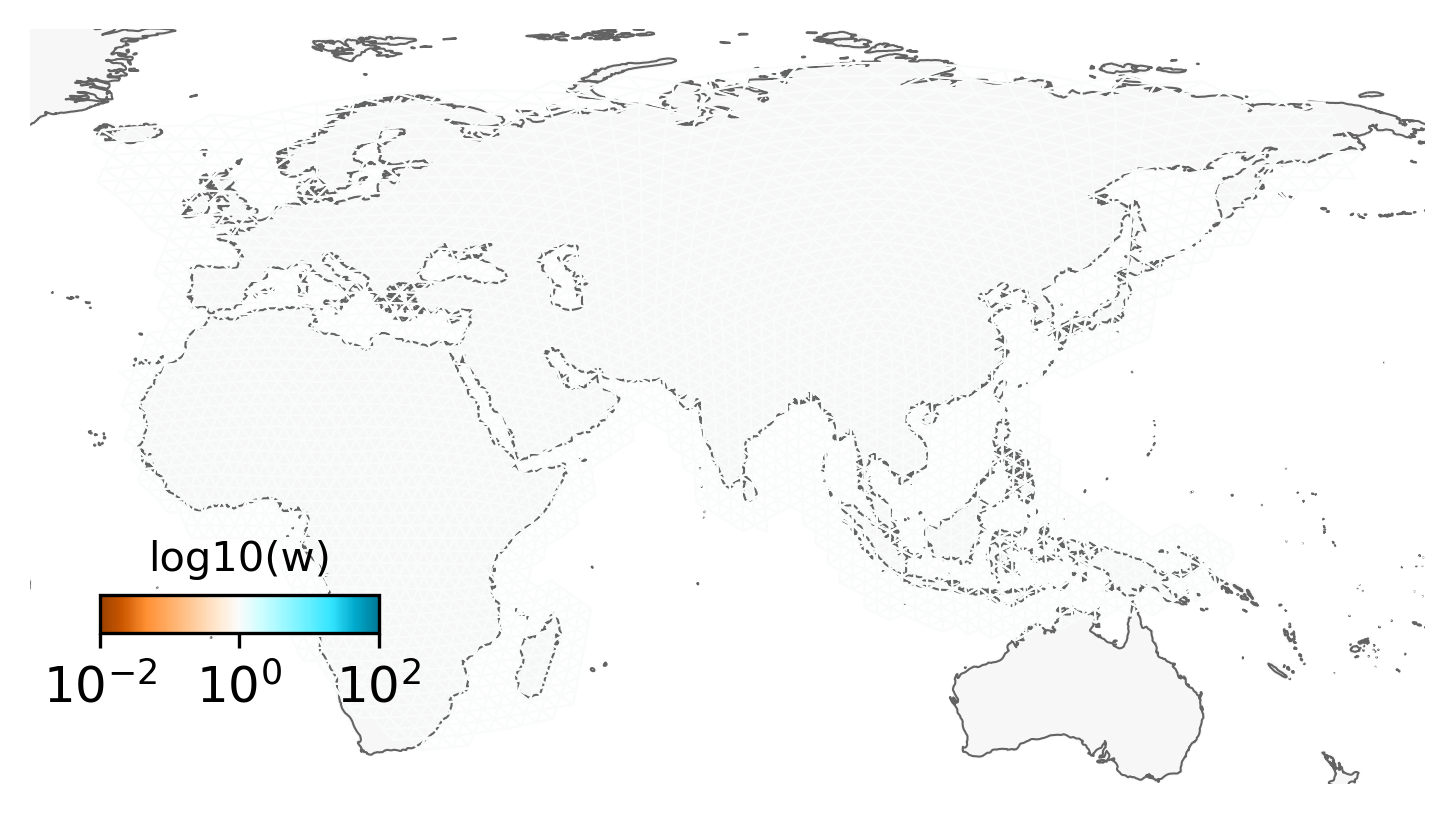

In [7]:
%matplotlib inline 

fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10);
v.draw_map();
v.draw_edges(use_weights=True);
v.draw_edge_colorbar();
v.art = [];
v.legend = None;

In [8]:
def draw_assignment_prob(v, p, assignment_prob, projection, sp_graph, label, color='red'):
    """
    draw assignment probabilities for one sample point
    """    
    # draw sample point
    permuted_idx = query_node_attributes(v.sp_graph, "permuted_idx")
    grid = v.grid[permuted_idx]
    jitter = grid + np.random.normal(size=grid.shape)
    p1 = sample_point=v.ax.scatter(
        grid[:, 0],
        grid[:, 1],
        edgecolors=color,
        linewidth=v.sample_pt_linewidth,
        s=assignment_prob * 300,
        alpha=0.5,
        color=color,
        marker=".",
        zorder=v.sample_pt_zorder,
        label = label
    )
    
    
    # draw sample point
    pproj = project_coords(np.atleast_2d(p), v.proj)
    p2 = assignment_prob = v.ax.scatter(
        pproj[:, 0],
        pproj[:, 1],
        edgecolors='k',
        linewidth=v.sample_pt_linewidth,
        s=100,
        alpha=v.sample_pt_alpha,
        color='k',
        marker="*",
        zorder=v.sample_pt_zorder
    )
    
    v.art.append((p1, p2))

In [9]:
methods = [
    'feems_point_noreg', 'ibd_point_noreg',
    'feems_point_alpha-0.1', 'ibd_point_alpha-0.1',
    'feems_point_alpha-0.5', 'ibd_point_alpha-0.5']

In [18]:
results = {}
for method in methods:
    print(method)
    paths = result_paths('feems', method)
    _results = [pickle.load(open(f, 'rb')) for f in paths];
    
    post_assignment = []
    true_coord = []
    for r in _results:
        pred_idx = r['pred_idx']
        post_assignment.append(r['post_assignment'])  # sort?
        true_coord.append(coord.values[pred_idx])
    true_coord = np.concatenate(true_coord)
    post_assignment = np.concatenate(post_assignment)

    for i in range(true_coord.shape[0]):
        key = tuple(true_coord[i])
        if key not in results:
            results[key] = {
                method: post_assignment[i],
            }
        else:
            results[key][method] = post_assignment[i]

feems_point_noreg
ibd_point_noreg
feems_point_alpha-0.1
ibd_point_alpha-0.1
feems_point_alpha-0.5
ibd_point_alpha-0.5


In [19]:
method2color = {
    'feems_point_noreg': '#b30000',
    'feems_point_alpha-0.1': '#fc8d59',
    'feems_point_alpha-0.5': '#fdd49e',
    'ibd_point_noreg': '#0868ac',
    'ibd_point_alpha-0.1': '#7bccc4',
    'ibd_point_alpha-0.5': '#ccebc5'
}

In [20]:
keys = list(results.keys())

METHODS = [
    'feems_point_noreg',
    #'feems_point_alpha-0.1',
    #'feems_point_alpha-0.5',
    'ibd_point_noreg',
    #'ibd_point_alpha-0.1',
    #'ibd_point_alpha-0.5'
]

def plot_func(idx):
    while len(v.art) > 0:
        [x.remove() for x in v.art.pop()];
    if v.legend is not None:
        v.legend.remove()
        v.legend = None
    
    R = results[keys[idx]]
    point = np.array(keys[idx])
    
    for method in np.intersect1d(METHODS, list(R.keys())):
        draw_assignment_prob(v, point, np.exp(R[method]), projection, sp_graph, label=method, color=method2color.get(method, 'k'))
    
    v.legend = v.ax.legend(loc='upper right', bbox_to_anchor=(0.4, 1.2), fontsize='xx-small', markerscale=1.0)
    return fig

%matplotlib notebook
interact(plot_func, idx = widgets.IntSlider(value=0, min=0, max=100.0))

interactive(children=(IntSlider(value=0, description='idx'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_func(idx)>